# Prediciendo resultados de carreras de caballos
El presente trabajo tiene por objetivo presentar un modelo para predecir que probabilidades de ganar tiene cada caballo en una determinada carrera y luego evaluar de que forma se pueden usar esas predicciones en una estrategia de inversión con el objetivo de maximizar el rendimiento obtenido sobre las apuestas. En primer lugar planteamos consideraciones metodológicas especificas del problema para luego analizar la base de datos. Tercero, se explicará el proceso de ingeniería de atributos y se continuara con una explicación de la construcción de los modelos usados y sus resultados.

#### Librerias

In [241]:
rm(list = ls())

suppressPackageStartupMessages({
  library(randomForest)
  library(glmnet)
  library(rpart)  
  library(forcats)
  library(zoo)
  library(ROCR)
  library(pracma)
  library(survival)
  library(caret)
  library(parsnip)
  library(tidymodels)
  library(tidyverse)
  library(conflicted)
  library('ggpubr')
  library(RColorBrewer)
  library("viridis")  
  library(plotROC)
  library(splines)
  library(ggpubr)
})

suppressMessages(conflict_prefer_all('dplyr'))

In [242]:
options(scipen=999)
options(warn=-1)
options(repr.plot.width = 12, repr.plot.height =8)

#### Data
Los datos usados en este trabajo pueden encontrarse en el siguiente link
https://www.kaggle.com/datasets/gdaley/hkracing (CC0: Public Domain)

In [243]:
setwd('/Users/pilararamburu/Documents/GitHub/Horse_race_2022')

runs <- read.table('runs.csv', sep =',', dec = '.', header = T)
#head(runs,8); tail(runs,2); dim(runs) # 79447 x 37

races <- read.table('races.csv', sep =',', dec = '.', header = T)
#head(races,2); tail(races,2); dim(races) # 6349 x 37

df_list <- list(runs, races)
raceruns <- df_list %>% reduce(full_join, by='race_id')
rm(list = c('races','runs', 'df_list'))
head(raceruns,8)
print(dim(raceruns))
raceruns$date <- as.Date(raceruns$date)

,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,horse_rating,⋯,place_combination3,place_combination4,place_dividend1,place_dividend2,place_dividend3,place_dividend4,win_combination1,win_dividend1,win_combination2,win_dividend2
,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,0,1,3917,10,0,8.00,3,AUS,Gelding,60,⋯,6,NA,36.5,25.5,18,NA,8,121,NA,NA
2,0,2,2157,8,0,5.75,3,NZ,Gelding,60,⋯,6,NA,36.5,25.5,18,NA,8,121,NA,NA
3,0,3,858,7,0,4.75,3,NZ,Gelding,60,⋯,6,NA,36.5,25.5,18,NA,8,121,NA,NA
4,0,4,1853,9,0,6.25,3,SAF,Gelding,60,⋯,6,NA,36.5,25.5,18,NA,8,121,NA,NA
5,0,5,2796,6,0,3.75,3,GB,Gelding,60,⋯,6,NA,36.5,25.5,18,NA,8,121,NA,NA
6,0,6,3296,3,0,1.25,3,NZ,Gelding,60,⋯,6,NA,36.5,25.5,18,NA,8,121,NA,NA
7,0,7,911,12,0,9.50,3,NZ,Gelding,60,⋯,6,NA,36.5,25.5,18,NA,8,121,NA,NA
8,0,8,2170,1,1,0.00,3,AUS,Gelding,60,⋯,6,NA,36.5,25.5,18,NA,8,121,NA,NA


[1] 79448    73


#### Procesamiento de datos

In [244]:
# Tratamiento de missings
raceruns[is.na(raceruns$won) , 'won'] = 0

# Variables categoricas
raceruns$surface    <- as.factor(raceruns$surface) 
raceruns$race_class <- as.factor(raceruns$race_class)
raceruns$draw   <- as.factor(raceruns$draw)
raceruns$horse_country <- as.factor(raceruns$horse_country) 
raceruns$horse_type <- as.factor(raceruns$horse_type)
raceruns$trainer_id <- as.factor(raceruns$trainer_id)
raceruns$jockey_id <- as.factor(raceruns$jockey_id)
raceruns$venue <- as.factor(raceruns$venue)
raceruns$config <- as.factor(raceruns$config)
raceruns$going <- as.factor(raceruns$going)
raceruns$horse_ratings <- as.factor(raceruns$horse_ratings)
raceruns$race_class <- as.factor(raceruns$race_class)


#### Data disponible
Contamos con datos para 6349 carreras que tuvieron lugar en Hong Kong a lo largo de 10 años. Tenemos un total de 79448 observaciones, donde encontramos 4406 caballos distintos, 187 jinetes y 177 entrenadores.


In [245]:
# Dejamos las ultimas 600 carreras como Hold out data set 
index_train = which(raceruns$race_id < (max(raceruns$race_id) - 600))
index_test = which(raceruns$race_id >= (max(raceruns$race_id) - 600))

# Lista de columnas que no usamos: Muchos valores, muchos missing o informacion no disponible en la carrera 

drop_columnas = c("race_id", "horse_no", "horse_id", "result", "lengths_behind" , "horse_gear", 
                  "position_sec1" , "position_sec2" , "position_sec3" , "position_sec4" , "position_sec5", "position_sec6",
                  "behind_sec1", "behind_sec2" ,"behind_sec3" ,"behind_sec3", "behind_sec4" ,"behind_sec5","behind_sec6",
                  "time1.x",  "time2.x"  ,  "time3.x" ,  "time4.x" ,  "time5.x" ,  "time6.x",  "finish_time",
                  "finish_time", "trainer_id" , "jockey_id" , "date" ,"race_no" , 
                  "sec_time1" , "sec_time2" , "sec_time3", "sec_time4" , "sec_time5" , "sec_time6", "sec_time7",
                  "time1.y", "time2.y", "time3.y" , "time4.y", "time5.y", "time6.y" , "time7.y", "time7",
                  "place_combination1", "place_combination2", "place_combination3", "place_combination4",
                  "win_combination1", "win_dividend1", "win_combination2", "win_dividend2" , "place_odds",
                  "place_dividend1", "place_dividend2", "place_dividend3", "place_dividend4",
                  "podio_dummy" , "podio")

columnas = colnames(raceruns)
filtro = which(columnas %in% drop_columnas )
cols_x_y_odds_include =  columnas[-filtro]

# Filtro odds
filtro_odds = which(columnas %in% c(drop_columnas, "win_odds" ))
cols_x_y_odds_not_include = columnas[-filtro_odds]
target = c("won")


#### Analisis exploratorio

`summarise()` has grouped output by 'horse_id'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'horse_id'. You can override using the
`.groups` argument.


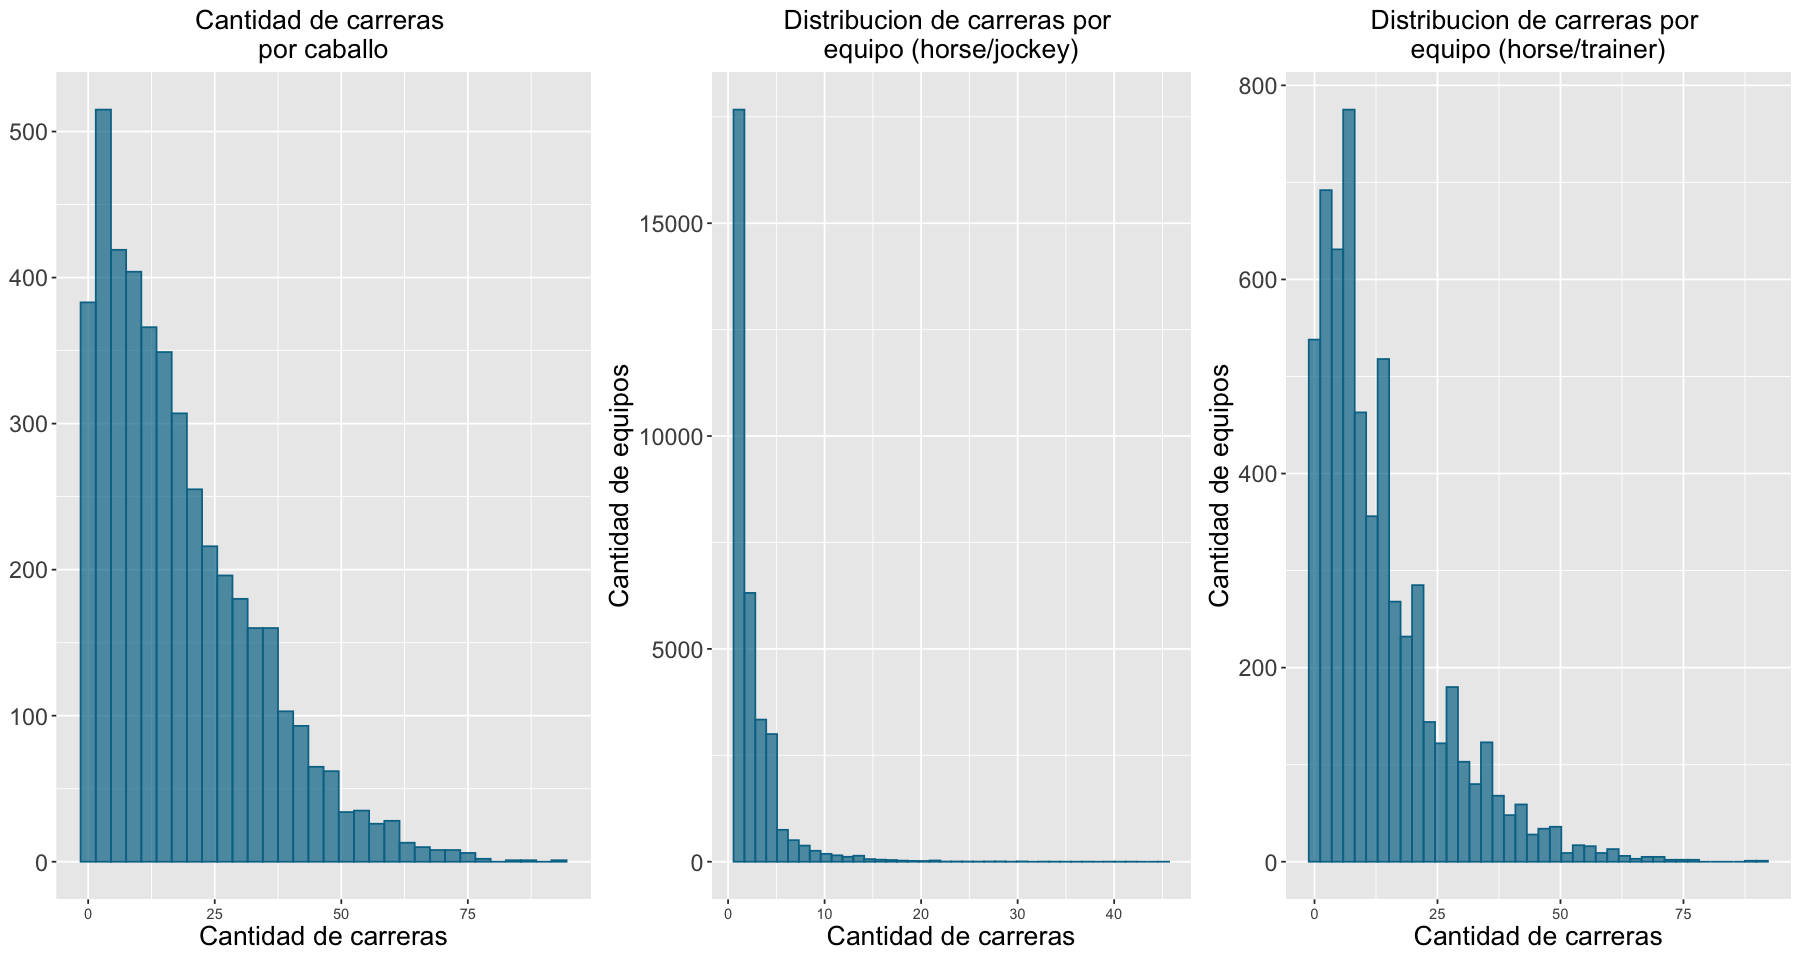

In [351]:
colors = c(Frecuentes = '#99E2B4', Nuevos = '#007496')
options(repr.plot.width = 15, repr.plot.height =8)

by_horse = raceruns %>% 
            group_by(horse_id) %>% 
            summarise(perc_wins = mean(won),
            cant_carreras = length(horse_id)) %>%
            ungroup()
            
hist_horse <- ggplot(by_horse, aes(cant_carreras)) + 
                geom_histogram(binwidth = 3, color = '#007496', fill = '#007496', alpha = 0.7) + 
                ggtitle('Cantidad de carreras \npor caballo') +
                xlab('Cantidad de carreras') +
                theme(axis.title.y = element_blank(),
                      axis.title.x = element_text(size = 16),
                      plot.title = element_text(size = 16, hjust = 0.5),
                      axis.text.y = element_text(size = 14))

# consideramos experimentados a los caballos que jugaron 15 o mas carreras 
by_horse_frec = by_horse %>% 
  filter(cant_carreras >= 15, 
          perc_wins < 0.5)

by_horse_no_frec = by_horse %>% 
  filter(cant_carreras < 15,
          perc_wins < 0.5)

horse_exp_nuevos <- ggplot() + 
                          geom_histogram(data = by_horse_frec, aes(perc_wins, y = ..density.., fill = 'Frecuentes', color = 'Frecuentes'), 
                                        bins = 30,
                                        alpha = 0.6) + 
                          geom_histogram(data = by_horse_no_frec, aes(perc_wins, y = ..density.., fill = 'Nuevos', color = 'Nuevos'), 
                                        bins = 30, 
                                        alpha = 0.6) +
                          labs(x = 'proporcion de victorias') + 
                          scale_fill_manual(name = '',values = colors) +
                          scale_color_manual(name = '',values = colors) +
                          ggtitle('Proporcion de victorias en caballos \nnuevos y experimentados') +
                          theme(axis.title.x = element_text(size = 16),
                                plot.title = element_text(size = 16, hjust = 0.5),
                                axis.text.x = element_text(size = 14),
                                axis.text.y = element_text(size = 14),
                                legend.key.size = unit(1, 'cm'), 
                                legend.key.height = unit(1, 'cm'), 
                                legend.key.width = unit(1, 'cm'),
                                legend.text = element_text(size=16))

## Horse and jockey ##
by_horse_jockey = raceruns %>%
  group_by(horse_id, jockey_id) %>%
  summarise(cant_carreras = length(won),
            perc_won = mean(won))

# combinaciones frecuentes
by_horse_jockey_frec = by_horse_jockey %>% 
  filter(cant_carreras >= 5) %>%
  arrange(desc(perc_won))

by_horse_jockey_no_frec = by_horse_jockey %>% 
  filter(cant_carreras < 5) %>%
  arrange(desc(perc_won))

hist_horse_jockey <- ggplot(by_horse_jockey, aes(cant_carreras)) + 
                        geom_histogram(bins=40, color = '#007496', fill = '#007496', alpha = 0.7) +
                        labs(x = 'Cantidad de carreras', y = 'Cantidad de equipos') +
                        ggtitle('Distribucion de carreras por \nequipo (horse/jockey)') +
                        theme(plot.title = element_text(size = 16, hjust = 0.5),
                                axis.text.y = element_text(size = 14),
                                axis.title.x = element_text(size = 16),
                                axis.title.y = element_text(size = 16))

horse_jockey_exp_nuevo <- ggplot() + 
                              geom_histogram(data = by_horse_jockey_frec, aes(perc_won, y = ..density.., fill = 'Frecuentes', color = 'Frecuentes'), 
                                            bins = 30,
                                            alpha = 0.6) + 
                              geom_histogram(data = by_horse_jockey_no_frec, aes(perc_won, y = ..density.., fill = 'Nuevos', color = 'Nuevos'), 
                                            bins = 30,
                                            alpha = 0.6) +
                              labs(x = 'proporcion de victorias') + 
                              scale_fill_manual(name = '',values = colors) +
                              scale_color_manual(name = '',values = colors) +
                              ggtitle('Proporcion de victorias en equipos \nhorse/jockey nuevos y experimentados') +
                              theme(axis.title.x = element_text(size = 16),
                                    plot.title = element_text(size = 16, hjust = 0.5),
                                    axis.text.x = element_text(size = 14),
                                    axis.text.y = element_text(size = 14),
                                    legend.key.size = unit(1, 'cm'), 
                                    legend.key.height = unit(1, 'cm'), 
                                    legend.key.width = unit(1, 'cm'),
                                    legend.text = element_text(size=16))

## Horse and trainer ##
by_horse_trainer = raceruns %>%
  group_by(horse_id, trainer_id) %>%
  summarise(cant_carreras = length(won),
            perc_won = mean(won))

by_horse_trainer_frec = by_horse_trainer %>% 
  filter(cant_carreras >= 5) %>%
  arrange(desc(perc_won))

by_horse_trainer_no_frec = by_horse_trainer %>% 
  filter(cant_carreras < 5) %>%
  arrange(desc(perc_won))

hist_horse_trainer <- ggplot(by_horse_trainer, aes(cant_carreras)) + 
                          geom_histogram(bins=40, color = '#007496', fill = '#007496', alpha = 0.7) +
                          labs(x = 'Cantidad de carreras', y = 'Cantidad de equipos') +
                          ggtitle('Distribucion de carreras por \nequipo (horse/trainer)') +
                          theme(plot.title = element_text(size = 16, hjust = 0.5),
                                  axis.text.y = element_text(size = 14),
                                  axis.title.x = element_text(size = 16),
                                  axis.title.y = element_text(size = 16))

horse_trainer_exp_nuevo <- ggplot() + 
                              geom_histogram(data = by_horse_trainer_frec, aes(perc_won, y = ..density.., fill = 'Frecuentes', color = 'Frecuentes'),
                                            bins = 30,
                                            alpha = 0.6) + 
                              geom_histogram(data = by_horse_trainer_no_frec, aes(perc_won, y = ..density.., fill = 'Nuevos', color = 'Nuevos'),
                                            bins = 30,
                                            alpha = 0.6) +
                              labs(x = 'proporcion de victorias') + 
                              scale_fill_manual(name = '',values = colors) +
                              scale_color_manual(name = '',values = colors) +
                              ggtitle('Proporcion de victorias en equipos \nhorse/trainer nuevos y experimentados') +
                              theme(axis.title.x = element_text(size = 16),
                                    plot.title = element_text(size = 16, hjust = 0.5),
                                    axis.text.x = element_text(size = 14),
                                    axis.text.y = element_text(size = 14),
                                    legend.key.size = unit(1, 'cm'), 
                                    legend.key.height = unit(1, 'cm'), 
                                    legend.key.width = unit(1, 'cm'),
                                    legend.text = element_text(size=16))            

ggarrange(hist_horse, hist_horse_jockey, hist_horse_trainer, ncol = 3)                       

En este grafico podemos ver la distribucion de la cantidad de carreras corridas por caballo, donde la mayoria de los caballos corrieron entre 1 y 15 carreras. Si miramos la distribucion de carreras por equipo de caballo y jockey, vemos que no es usual que los caballos corran muchas veces con el mismo jinete, ya que la mayoría de estos equipos horse/jockey corrieron entre 1 y 2 carreras. Por último, resaltamos que si es usual que los caballos matengan el mismo entrenador durante varias carreras, donde la mayoría de los equipos horse/trainer corrieron alrededor de 10 carreras. Sin embargo, destacamos que en todos los casos hay caballos o equipos que tienen mas experiencia que la mayoría, ya sea por separado o en conjunto, lo cual puede influir en la performance del caballo.

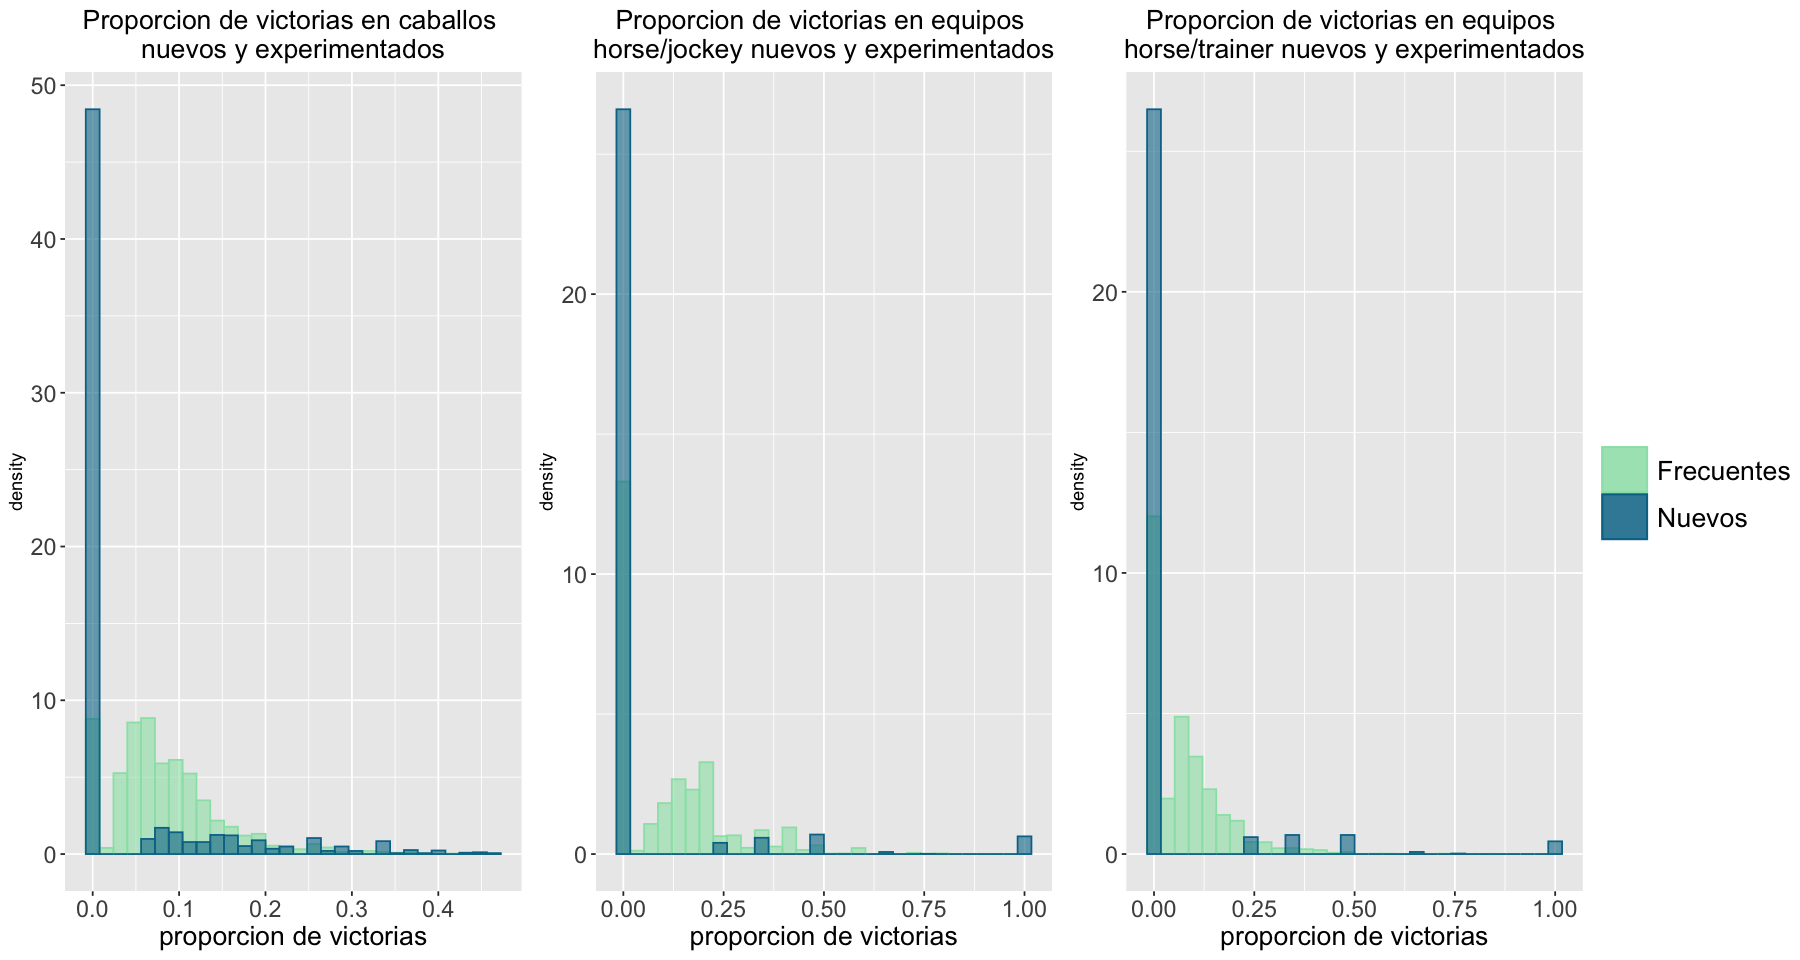

In [352]:
legend = get_legend(horse_exp_nuevos)
ggarrange(horse_exp_nuevos, horse_jockey_exp_nuevo, horse_trainer_exp_nuevo, ncol = 3, legend.grob = legend, legend = 'right') 

Graficamos la proporcion de victorias de victorias del caballo y de los equipos horse/jockey y horse/trainer, distinguiendo si son nuevos o frecuentes. En el caso de los caballos, consideramos experimentados a los que corrieron mas de 15 carreras, y vemos que los caballos experimentados suelen tener proporciones de victorias mas altas que los nuevos. Analogamente encontramos que la proporcion de victorias es mayor en los equipos horse/jockey o horse/trainer frecuentes, es decir, aquellas combinaciones de caballo-entrenador o caballo-jinete que corrieron mas de 5 carreras juntos.

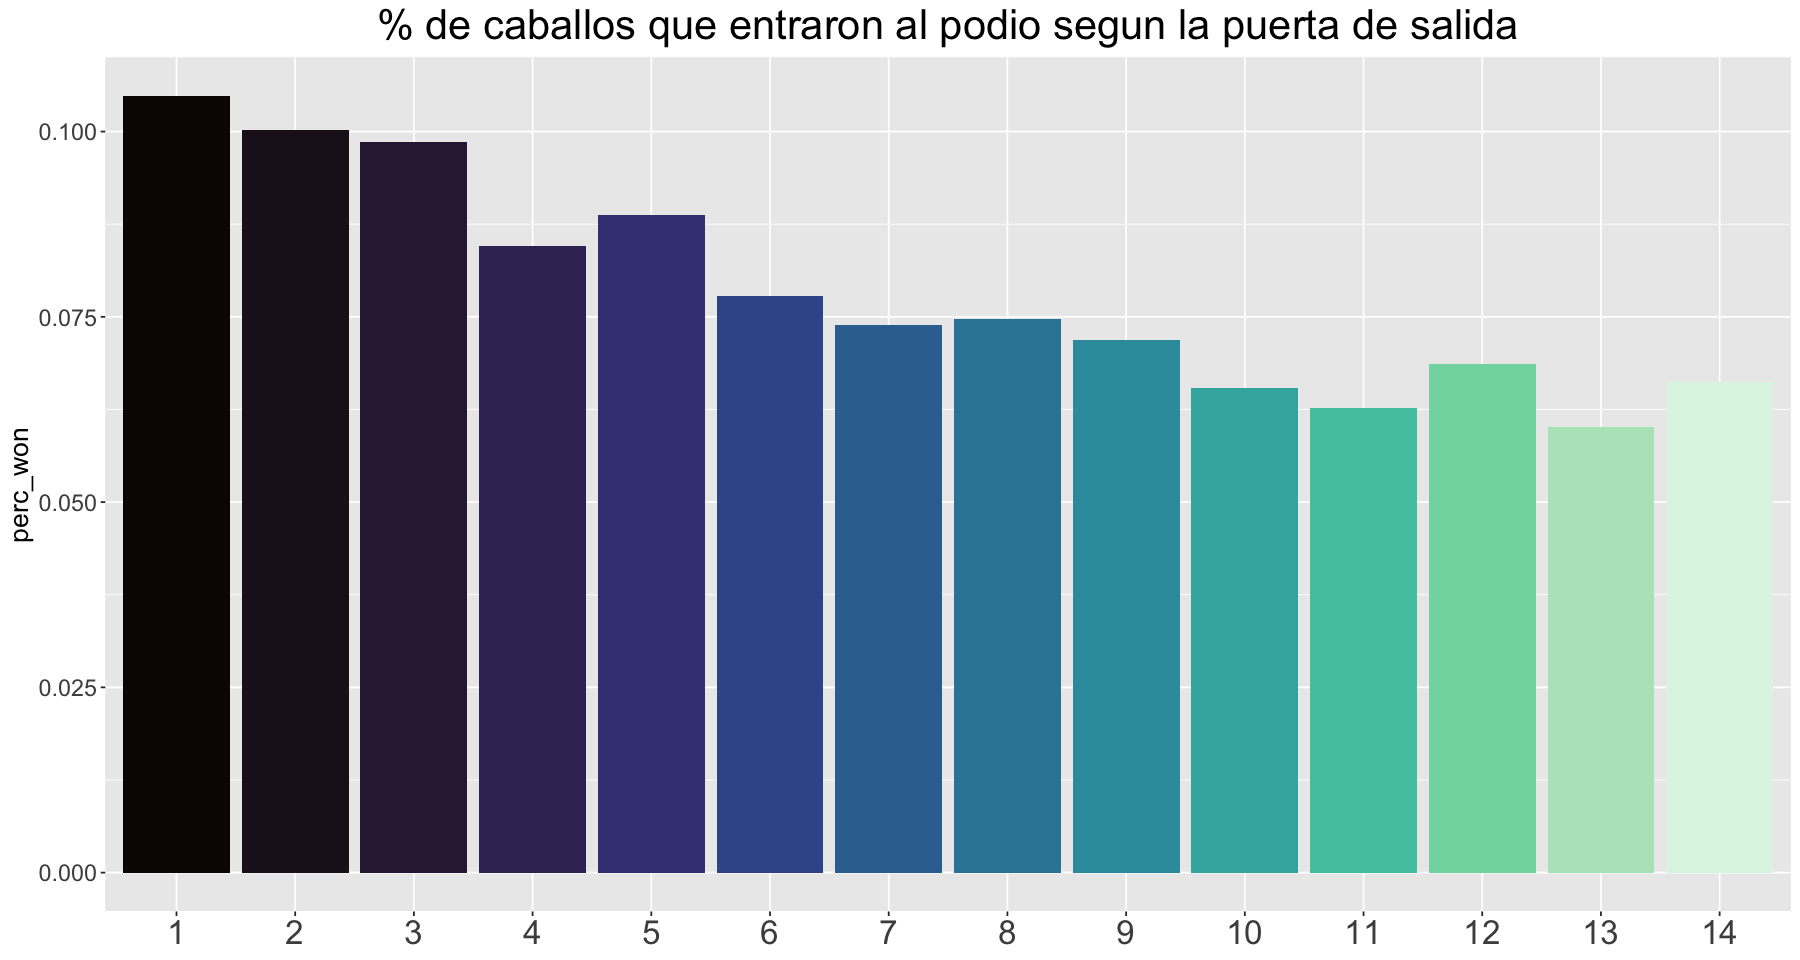

In [350]:
## BY DRAW ##
by_draw = raceruns %>%
  group_by(draw) %>%
  summarise(perc_won = mean(won),
            rdo_promedio = mean(result)) %>%
  ungroup() 

by_draw = by_draw %>%
  filter(perc_won > 0.0000) 


ggplot(by_draw, aes(draw, perc_won, fill = draw)) + 
  geom_col() + 
  scale_fill_viridis(discrete = TRUE, option = 'mako') +
  ggtitle('% de caballos que entraron al podio segun la puerta de salida')  +
  theme(axis.title.x = element_blank(),
        axis.title.y = element_text(size = 16),
        legend.position = 'none',
        plot.title = element_text(size = 25, hjust = 0.5),
        axis.text.x = element_text(size = 20),
        axis.text.y = element_text(size = 14))


La puerta de salida tambien influye en la proporcion de victorias, donde hay una mayor proporcion de victorias en las primeras puertas y menor en las últimas.

##### Clases desbalanceadas
Dado que vamos a intentar predecir la variable “won”, que toma valor 1 si el caballo gana la carrera y 0 en caso contrario, nos enfrentamos a un problema de clases naturalmente desbalanceadas, ya que solo puede haber un ganador por carrera. Observamos que solo el 8% de las observaciones corresponden a caballos ganadores.

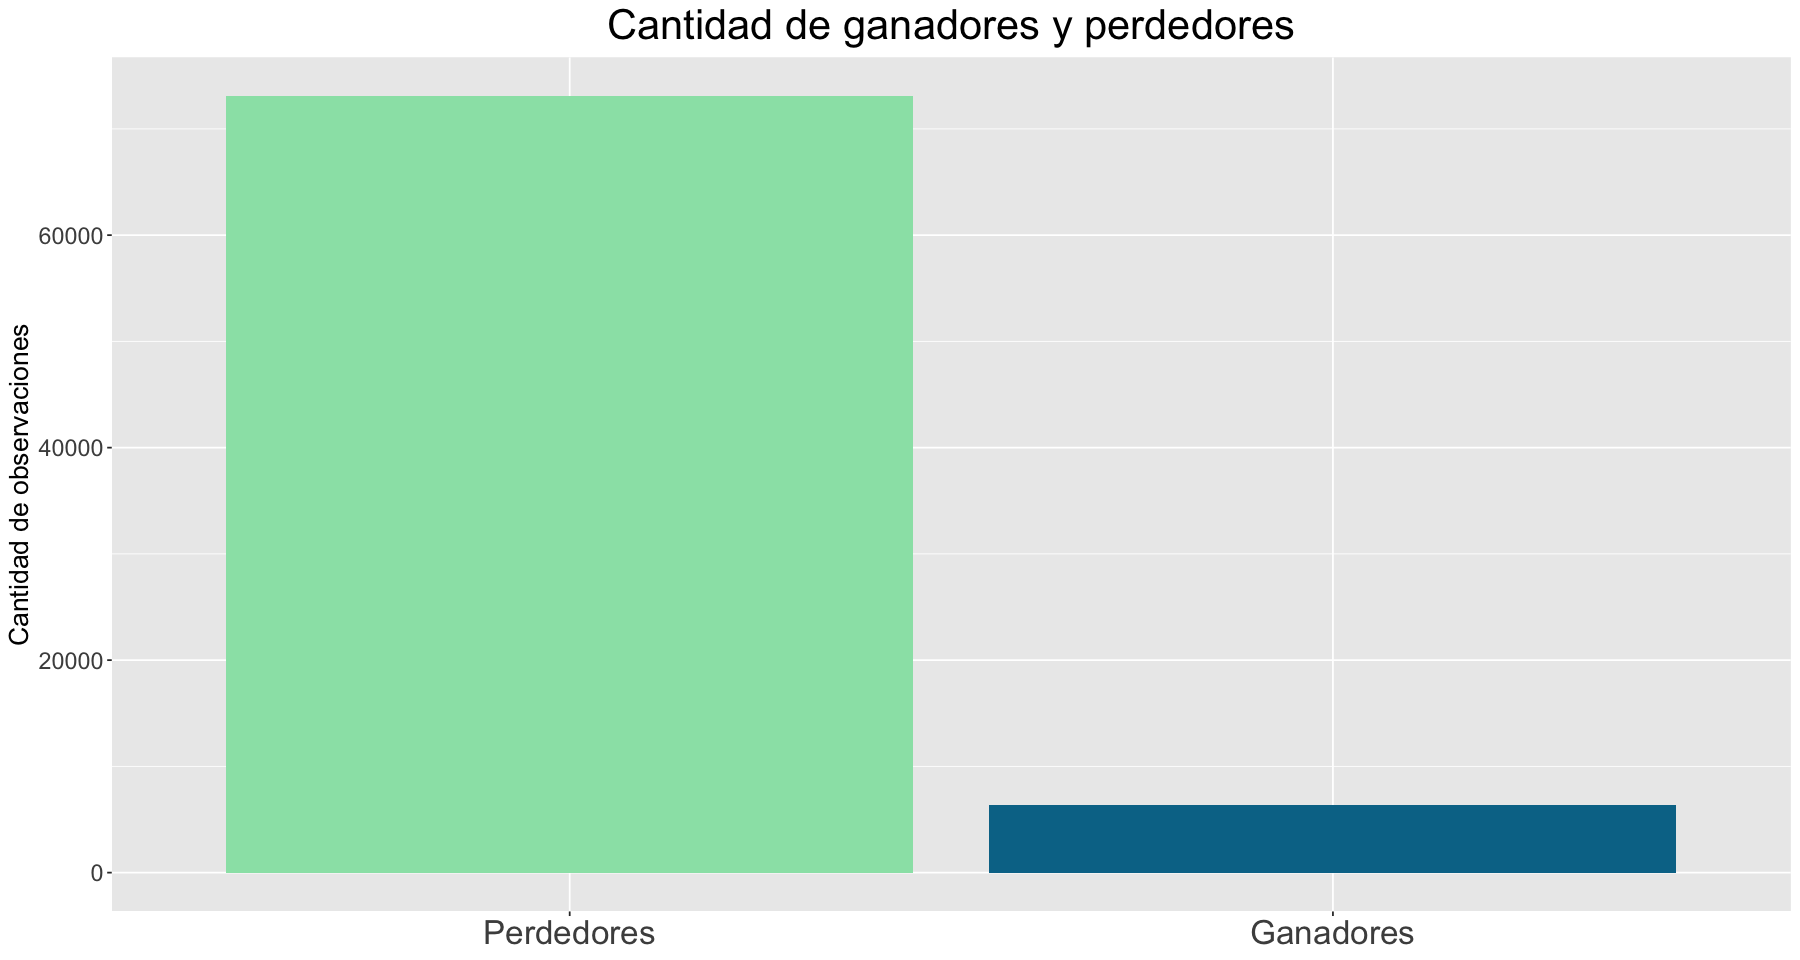

In [348]:
ggplot(raceruns, aes(factor(won), fill = factor(won))) +
  geom_bar() +
  scale_x_discrete(na.translate = FALSE, labels = c('0'='Perdedores', '1'='Ganadores')) +
  scale_fill_manual(values = c('#99E2B4', '#007496')) +
  ggtitle("Cantidad de ganadores y perdedores") +
  ylab('Cantidad de observaciones') +
  theme(axis.title.x = element_blank(),
        axis.title.y = element_text(size = 16),
        legend.position = 'none',
        plot.title = element_text(size = 25, hjust = 0.5),
        axis.text.x = element_text(size = 20),
        axis.text.y = element_text(size = 14))

#### Modelo 1: Benchmark
Estimamos un logit sobre los datos con un procesamiento minimo, sin feature_engineering

In [247]:
## Fit en train ## 
benchmark = glmnet(y = data.matrix(raceruns[index_train , target]) ,
               x = data.matrix(raceruns[index_train , cols_x_y_odds_include] %>% select(-won)),
               family  = 'binomial',
               lambda = 0,  
               alpha = 1)


## Predicciones ##
pred_benchmark <- predict(benchmark, 
                s = 0, 
                newx =data.matrix(raceruns[index_test , cols_x_y_odds_include] %>% select(-won)), type = 'response')

pred_benchmark = as.data.frame(pred_benchmark)
pred_benchmark[!complete.cases(pred_benchmark), ] = 0
colnames(pred_benchmark) = c('prediccion')

won_b = raceruns[index_test, target]

#### Feature Engineering

A fin de considerar la performance pasada del caballo incluimos en el modelo las siguientes features:

- Proporción de victorias y podios en las 2, 3 y 5 carreras anteriores.
- Dummy que indica si ganó o no la carrera anterior.
- Dias de descanso del caballo, calculado cómo los días transcurridos desde la ultima carrera que corrió.
- Experiencia del caballo, calculada como la cantidad de carreras que corrió el caballo hasta ese momento.
- Cantidad de victorias y podios que el caballo acumula hasta ese momento.
- Cantidad de carreras que el caballo corrió con ese jinete hasta ese momento.
- Cantidad de carreras que el caballo corrió con ese entrenador hasta ese momento.

También incluimos una serie de features que buscan representar la performance pasada del jinete:
- Proporción de victorias y podios en las 2, 3, 5, 10 y 20 carreras anteriores.
- Dummy que indica si ganó o no la carrera anterior.
- Dias de descanso del jinete.
- Experiencia del jinete.
- Cantidad de victorias y podios que el jinete acumula hasta ese momento.

Elegimos calcular estas variables que varían en el tiempo y se actualizan a medida que van ocurriendo las nuevas carreras en lugar de, por ejemplo, una probabilidad constante de victoria de cada caballo, porque consideramos que esta performance no es constante. Intentamos capturar el hecho de que un caballo que recién empezó a correr no va a tener la misma probabilidad de victorias que ese mismo caballo luego de correr 10 carreras, o que la habilidad del caballo puede variar en el tiempo, y que por eso resulta mas conveniente mirar la performance en las ultimas carreras en vez de alguna medida de performance global.

Por ultimo construimos algunas variables para incorporar la competencia, ya que la probabilidad de victoria de un caballo no solo depende de sus propias características sino también de las de sus competidores. Calculamos, para cada observación, la distancia respecto del máximo, del mínimo y del promedio de esa carrera para varias de las variables. Por ejemplo, calculamos para cada caballo, la diferencia de su edad respecto del caballo más viejo de la competencia, del más joven y del promedio. Hacemos lo mismo para el rating asignado por HKJC, el peso que cargan, el peso del caballo, la experiencia y la cantidad de victorias y podios pasados del caballo y del jinete, la proporción de victorias en las ultimas carreras del caballo y del jinete, y la cantidad de carreras que el caballo corrió con ese jinete y con ese entrenador. También probamos otra forma de incorporar la competencia, estandarizando el valor de la variable usando los datos de esa carrera (por ejemplo: a la edad de un caballo particular le restamos el promedio de la carrera y lo dividimos por el desvío estándar de la edad en esa carrera).

In [250]:
## Variable podio ##
raceruns['podio'] = ifelse(raceruns$result > 3, 0, raceruns$result)
raceruns['podio_dummy'] = ifelse(raceruns$result > 3, 0, 1)

## performance ultimas carreras ##
raceruns <- raceruns%>%
  group_by(horse_id) %>%
  arrange(horse_id,date) %>%
  mutate(horse_won_last_five=rollapply(lag(won),5,mean,align='right',fill=0),
         horse_podio_last_five = rollapply(lag(podio_dummy),5, mean, align = 'right', fill = 0),
         horse_won_last_race = lag(won),
         horse_podio_last_race = lag(podio_dummy),
         horse_result_last_race = lag(result),
         horse_won_last_two = rollapply(lag(won),2,mean,align='right',fill=0),
         horse_podio_last_two = rollapply(lag(podio_dummy),2, mean, align = 'right', fill = 0),
         horse_won_last_three=rollapply(lag(won),3,mean,align='right',fill=0),
         horse_podio_last_three = rollapply(lag(podio_dummy),3, mean, align = 'right', fill = 0)
         )%>%
  ungroup()

raceruns <- raceruns%>%
  group_by(jockey_id) %>%
  arrange(jockey_id,date) %>%
  mutate(jockey_won_last_five=rollapply(lag(won),5,mean,align='right',fill=NA),
         jockey_podio_last_five = rollapply(lag(podio_dummy),5, mean, align = 'right', fill = NA),
         jockey_won_last_race = lag(won),
         jockey_podio_last_race = lag(podio_dummy),
         jockey_result_last_race = lag(result),
         jockey_won_last_two = rollapply(lag(won),2,mean,align='right',fill=NA),
         jockey_podio_last_two = rollapply(lag(podio_dummy),2, mean, align = 'right', fill = NA),
         jockey_won_last_three=rollapply(lag(won),3,mean,align='right',fill=NA),
         jockey_podio_last_three = rollapply(lag(podio_dummy),3, mean, align = 'right', fill = NA),         
         jockey_won_last_ten=rollapply(lag(won),10,mean,align='right',fill=NA),
         jockey_podio_last_ten = rollapply(lag(podio_dummy),10, mean, align = 'right', fill = NA),
         jockey_won_last_twenty=rollapply(lag(won),20,mean,align='right',fill=NA),
         jockey_podio_last_twenty = rollapply(lag(podio_dummy),20, mean, align = 'right', fill = NA))%>%
  ungroup()

## days between races horses and jockeys (dias de descanso) ##
raceruns <- raceruns %>%
  group_by(horse_id) %>%
  arrange(horse_id, date) %>%
  mutate(horse_rest = as.numeric(date - lag(date))) %>%
  ungroup() %>%
  group_by(jockey_id) %>%
  arrange(jockey_id, date) %>%
  mutate(jockey_rest = as.numeric(date - lag(date))) %>%
  ungroup()

## cantidad acumulada de carreras por caballo (experiencia) ##
raceruns <- raceruns %>%
  group_by(horse_id) %>%
  arrange(horse_id, date) %>%
  mutate(horse_experience = row_number()-1) %>%
  ungroup()
#ejemplo: si vale 4, corrio 4 carreras sin contar la actual

## cantindad acumulada de carreras ganadas por caballo ##
raceruns <- raceruns %>%
  group_by(horse_id) %>%
  arrange(horse_id, date) %>%
  mutate(horse_wins = lag(cumsum(won)),
         horse_podio = lag(cumsum(podio_dummy))) %>%
  ungroup()

## cantidad acumulada de carreras por jinete (experiencia) ##
raceruns <- raceruns %>%
  group_by(jockey_id) %>%
  arrange(jockey_id, date) %>%
  mutate(jockey_experience = row_number() -1) %>%
  ungroup()

## cantindad acumulada de carreras ganadas por jinete ##
raceruns <- raceruns %>%
  group_by(jockey_id) %>%
  arrange(jockey_id, date) %>%
  mutate(jockey_wins = lag(cumsum(won)),
         jockey_podio = lag(cumsum(podio_dummy))) %>%
  ungroup()

## cantidad acumulada de carreras por grupo de cabaallo y jinete (equipo conocido) ##
raceruns <- raceruns %>%
  group_by(horse_id, jockey_id) %>%
  arrange(horse_id,jockey_id, date) %>%
  mutate(horse_and_jockey_experience = row_number()) %>%
  ungroup()

## cantidad acumulada de carreras por grupo de cabaallo y entrenador (equipo conocido) ##
raceruns <- raceruns %>%
  group_by(horse_id, trainer_id) %>%
  arrange(horse_id,trainer_id, date) %>%
  mutate(horse_and_trainer_experience = row_number()) %>%
  ungroup()

## variables de la competencia (alt 1) ##
raceruns <- raceruns %>% 
  group_by(race_id) %>%
  mutate(n_comp = length(horse_id),  # Cuanto caballos compiten
         
         max.age = max(horse_age, na.rm = T) - horse_age,  # Distancia respecto del caballo más viejo.
         min.age = horse_age - min(horse_age, na.rm = T),  # Distancia respecto del caballo más joven.
         avg.age = mean(horse_age, na.rm = T) - horse_age,  # Distancia respecto del caballo promedio.
         
         max.rating = max(horse_rating, na.rm = T) - horse_rating,  # Distancia respecto del caballo mejor calificado.
         min.rating = horse_rating - min(horse_rating, na.rm = T),  # Distancia respecto del caballo peor calificado.
         avg.ratin = mean(horse_rating, na.rm = T) - horse_rating,  # Distancia respecto del caballo promedio.
         
         max.aweight = max(actual_weight, na.rm = T) - actual_weight,  # Distancia respecto del caballo que mas carga.
         min.aweight = actual_weight - min(actual_weight, na.rm = T),  # Distancia respecto del caballo que menos carga.
         avg.aweight = mean(actual_weight, na.rm = T) - actual_weight,  # Distancia respecto del caballo promedio.
         
         max.dweight = max(declared_weight, na.rm = T) - declared_weight,  # Distancia respecto del caballo mas pesado
         min.dweight = declared_weight - min(declared_weight, na.rm = T),  # Distancia respecto del caballo mas liviano
         avg.dweight = mean(declared_weight, na.rm = T) - declared_weight,  # Distancia respecto del caballo promedio.
         
         max.horse_wins = max(horse_wins, na.rm = T) - horse_wins,  # Distancia respecto del caballo más ganador.
         min.horse_wins = horse_wins - min(horse_wins, na.rm = T),  # Distancia respecto del caballo menos ganador.
         avg.horse_wins = mean(horse_wins, na.rm = T) - horse_wins,  # Distancia respecto del caballo promedio.
         
         max.horse_podio = max(horse_podio, na.rm = T) - horse_podio,  # Distancia respecto del caballo con mas podios.
         min.horse_podio = horse_podio - min(horse_podio, na.rm = T),  # Distancia respecto del caballo con menos podios.
         avg.horse_podio = mean(horse_podio, na.rm = T) - horse_podio,  # Distancia respecto del caballo promedio.
         
         max.horse_experience = max(horse_experience, na.rm = T) - horse_experience,  # Distancia respecto del caballo más experimentado. 
         min.horse_experience = horse_experience - min(horse_experience, na.rm = T),  # Distancia respecto del caballo menos experimentado. 
         avg.horse_experience = mean(horse_experience, na.rm = T) - horse_experience,  # Distancia respecto del caballo promedio.
         
         max.jockey_wins = max(jockey_wins, na.rm = T) - jockey_wins,  # Distancia respecto del jinete más ganador.
         min.jockey_wins = jockey_wins - min(jockey_wins, na.rm = T),  # Distancia respecto del jinete menos ganador.
         avg.jockey_wins = mean(jockey_wins, na.rm = T) - jockey_wins,  # Distancia respecto del jinete promedio.
         
         max.jockey_podio = max(jockey_podio, na.rm = T) - jockey_podio,  # Distancia respecto del jinete con mas podios.
         min.jockey_podio = jockey_podio - min(jockey_podio, na.rm = T),  # Distancia respecto del jinete con menos podios.
         avg.jockey_podio = mean(jockey_podio, na.rm = T) - jockey_podio,  # Distancia respecto del jinete promedio.
         
         max.jockey_experience = max(jockey_experience, na.rm = T) - jockey_experience,  # Distancia respecto del jinete más experimentado.
         min.jockey_experience = jockey_experience - min(jockey_experience, na.rm = T),  # Distancia respecto del jinete menos experimentado.
         avg.jockey_experience = mean(jockey_experience, na.rm = T) - jockey_experience,  # Distancia respecto del jinete promedio.
         
         max.horse_and_jockey_experience = max(horse_and_jockey_experience, na.rm = T) - horse_and_jockey_experience,  # Distancia respecto del caballo-jinete más experimentado.
         min.horse_and_jockey_experience = horse_and_jockey_experience - min(horse_and_jockey_experience, na.rm = T),  # Distancia respecto del caballo-jinete menos experimentado.
         avg.horse_and_jockey_experience = mean(horse_and_jockey_experience, na.rm = T) - horse_and_jockey_experience,  # Distancia respecto del caballo promedio.
         
         max.horse_and_trainer_experience = max(horse_and_trainer_experience, na.rm = T) - horse_and_trainer_experience,  # Distancia respecto del caballo-entrenador más experimentado.
         min.horse_and_trainer_experience = horse_and_trainer_experience - min(horse_and_trainer_experience, na.rm = T),  # Distancia respecto del caballo-entrenador menos experimentado.
         avg.horse_and_trainer_experience = mean(horse_and_trainer_experience, na.rm = T) - horse_and_trainer_experience,  # Distancia respecto del caballo promedio.
         
         max.horse_won_last_five = max(horse_won_last_five, na.rm = T) - horse_won_last_five,  # Distancia respecto del caballo más ganador reciente.
         min.horse_won_last_five = horse_won_last_five - min(horse_won_last_five, na.rm = T),  # Distancia respecto del caballo menos ganador reciente.
         avg.horse_won_last_five = mean(horse_won_last_five, na.rm = T) - horse_won_last_five,  # Distancia respecto del caballo promedio.
         
         max.horse_podio_last_five = max(horse_podio_last_five, na.rm = T) - horse_podio_last_five,  # Distancia respecto del caballo con más podios recientes.
         min.horse_podio_last_five = horse_podio_last_five - min(horse_podio_last_five, na.rm = T),  # Distancia respecto del caballo con menos podios recientes.
         avg.horse_podio_last_five = mean(horse_podio_last_five, na.rm = T) - horse_podio_last_five,  # Distancia respecto del caballo promedio.
         
         max.jockey_won_last_five = max(jockey_won_last_five, na.rm = T) - jockey_won_last_five,  # Distancia respecto del jinete más ganador reciente.
         min.jockey_won_last_five = jockey_won_last_five - min(jockey_won_last_five, na.rm = T),  # Distancia respecto del jinete menos ganador reciente.
         avg.jockey_won_last_five = mean(jockey_won_last_five, na.rm = T) - jockey_won_last_five,  # Distancia respecto del jinete promedio.
         
         max.jockey_podio_last_five = max(jockey_podio_last_five, na.rm = T) - jockey_podio_last_five,  # Distancia respecto del jinete con más podios recientes.
         min.joceky_podio_last_five = jockey_podio_last_five - min(jockey_podio_last_five, na.rm = T),  # Distancia respecto del jinete con menos podios recientes.
         avg.jockey_podio_last_five = mean(jockey_podio_last_five, na.rm = T) - jockey_podio_last_five,  # Distancia respecto del jinete promedio.
  ) %>%
  ungroup()

## Variables de la competencia (alt 2) ##
raceruns <- raceruns %>% 
  group_by(race_id) %>%
  mutate(aweight_standard = (actual_weight - mean(actual_weight, na.rm = T))/sd(actual_weight, na.rm = T),
         dweight_standard = (declared_weight - mean(declared_weight, na.rm = T))/sd(declared_weight, na.rm = T),
         horse_wins_standard = (horse_wins - mean(horse_wins, na.rm = T))/sd(horse_wins, na.rm = T),
         horse_podio_standard = (horse_podio - mean(horse_podio, na.rm = T))/sd(horse_podio, na.rm = T),
         horse_experience_standard = (horse_experience - mean(horse_experience, na.rm = T))/sd(horse_experience, na.rm = T),
         jockey_wins_standard = (jockey_wins - mean(jockey_wins, na.rm = T))/sd(jockey_wins, na.rm = T),
         jockey_podio_standard = (jockey_podio - mean(jockey_podio, na.rm = T))/sd(jockey_podio, na.rm = T),
         jockey_experience_standard = (jockey_experience - mean(jockey_experience, na.rm = T))/sd(jockey_experience, na.rm = T),
         horse_and_jockey_experience_standard = (horse_and_jockey_experience - mean(horse_and_jockey_experience, na.rm = T))/sd(horse_and_jockey_experience, na.rm = T),
         horse_and_trainer_experience_standard = (horse_and_trainer_experience - mean(horse_and_trainer_experience, na.rm = T))/sd(horse_and_trainer_experience, na.rm = T),
         
         horse_podio_last_race_standard = (horse_podio_last_race - mean(horse_podio_last_race, na.rm = T))/sd(horse_podio_last_race, na.rm = T),
         horse_result_last_race_standard = (horse_result_last_race - mean(horse_result_last_race, na.rm = T))/sd(horse_result_last_race, na.rm = T),
         horse_won_last_five_standard = (horse_won_last_five - mean(horse_won_last_five, na.rm = T))/sd(horse_won_last_five, na.rm = T),
         horse_podio_last_five_standard = (horse_podio_last_five - mean(horse_podio_last_five, na.rm = T))/sd(horse_podio_last_five, na.rm = T),
         horse_won_last_two_standard = (horse_won_last_two - mean(horse_won_last_two, na.rm = T))/sd(horse_won_last_two, na.rm = T),
         horse_podio_last_two_standard = (horse_podio_last_two - mean(horse_podio_last_two, na.rm = T))/sd(horse_podio_last_two, na.rm = T),
         horse_won_last_three_standard = (horse_won_last_three - mean(horse_won_last_three, na.rm = T))/sd(horse_won_last_three, na.rm = T),
         horse_podio_last_three_standard = (horse_podio_last_three - mean(horse_podio_last_three, na.rm = T))/sd(horse_podio_last_three, na.rm = T),

         jockey_podio_last_race_standard = (jockey_podio_last_race - mean(jockey_podio_last_race, na.rm = T))/sd(jockey_podio_last_race, na.rm = T),
         jockey_result_last_race_standard = (jockey_result_last_race - mean(jockey_result_last_race, na.rm = T))/sd(jockey_result_last_race, na.rm = T),
         jockey_won_last_five_standard = (jockey_won_last_five - mean(jockey_won_last_five, na.rm = T))/sd(jockey_won_last_five, na.rm = T),
         jockey_podio_last_five_standard = (jockey_podio_last_five - mean(jockey_podio_last_five, na.rm = T))/sd(jockey_podio_last_five, na.rm = T),
         jockey_won_last_two_standard = (jockey_won_last_two - mean(jockey_won_last_two, na.rm = T))/sd(jockey_won_last_two, na.rm = T),
         jockey_podio_last_two_standard = (jockey_podio_last_two - mean(jockey_podio_last_two, na.rm = T))/sd(jockey_podio_last_two, na.rm = T),
         jockey_won_last_three_standard = (jockey_won_last_three - mean(jockey_won_last_three, na.rm = T))/sd(jockey_won_last_three, na.rm = T),
         jockey_podio_last_three_standard = (jockey_podio_last_three - mean(jockey_podio_last_three, na.rm = T))/sd(jockey_podio_last_three, na.rm = T),
         jockey_won_last_ten_standard = (jockey_won_last_ten - mean(jockey_won_last_ten, na.rm = T))/sd(jockey_won_last_ten, na.rm = T),
         jockey_podio_last_ten_standard = (jockey_podio_last_ten - mean(jockey_podio_last_ten, na.rm = T))/sd(jockey_podio_last_ten, na.rm = T),
         jockey_won_last_twenty_standard = (jockey_won_last_twenty - mean(jockey_won_last_twenty, na.rm = T))/sd(jockey_won_last_twenty, na.rm = T),
         jockey_podio_last_twenty_standard = (jockey_podio_last_twenty - mean(jockey_podio_last_twenty, na.rm = T))/sd(jockey_podio_last_twenty, na.rm = T)
  ) %>%
  ungroup()

In [251]:
#Volvemos a separar los datos luego del feature engineering
columnas = colnames(raceruns)
filtro = which(columnas %in% drop_columnas )

cols_x_y_odds_include =  columnas[-filtro]

#Filtro odds
filtro_odds = which(columnas %in% c(drop_columnas, "win_odds" ))

cols_x_y_odds_not_include = columnas[-filtro_odds]

target = c("won")

index_train = which(raceruns$race_id < (max(raceruns$race_id) - 600))
index_test = which(raceruns$race_id >= (max(raceruns$race_id) - 600))

#### Modelo 2: Logit con regularizacion Lasso

In [252]:
set.seed(1)
grid.l = logseq(0.0000000000001,50 ,50)
cv.out1 = cv.glmnet(x = data.matrix(raceruns[index_train , cols_x_y_odds_include] %>% select(-won)), 
                   y = data.matrix(raceruns[index_train , target]),
                   family = 'binomial',     # Modelo de regresión logística.
                   weights = NULL,          
                   type.measure= "auc",    
                   lambda = grid.l, 
                   alpha = 1,               # Lasso
                   nfolds = 5)
bestlam1 = cv.out1$lambda.1se


## Fit en train ##
lasso = glmnet(x =data.matrix(raceruns[index_train , cols_x_y_odds_include] %>% select(-won)), 
                    y = data.matrix(raceruns[index_train , target]),
                    family = 'binomial', 
                    alpha = 1,  
                    lambda = bestlam1) 


## Preducciones ##
pred_lasso = predict(lasso, s = bestlam1 , 
               newx =data.matrix(raceruns[index_test , cols_x_y_odds_include] %>% select(-won)), type = 'response') # ver slide 11
pred_lasso = as.data.frame(pred_lasso)
pred_lasso[!complete.cases(pred_lasso), ] = 0
colnames(pred_lasso) = c('prediccion')


Que variables usa el modelo para predecir?

In [253]:
print(rownames(coef(lasso, s = 'lambda.min'))[coef(lasso, s = 'lambda.min')[,1]!= 0]) ### returns nonzero coefs https://stackoverflow.com/questions/54984540/extracting-non-zero-coefficients-in-glmnet-in-r

[1] "(Intercept)" "win_odds"   


Al regularizar, el modelo predice solo usando la variable "win_odds" y el intercepto. Esta variable es un muy buen predictor de la probabilidad de victoria de un caballo ya que resume las expectativas del mercado sobre la performance de ese caballo. Sin embargo, predecir y apostar en base a esta variable únicamente no parece ser una estrategia muy rentable, ya que los caballos que el mercado percibe como ganadores van a pagar menos en caso de ganar.

#### Modelo 3: Logit en dos etapas: 
- 1ro Logit con regularización Lasso sin incluir la variable “win_odds”
- 2do Conditional Logit con las predicciones de la etapa 1 y la variable “win_odds”


##### 1ra Etapa
Teniendo en cuenta que la variable “win_odds” tiene mucho poder predictivo decidimos eliminarla en una primera etapa, para que el modelo pueda aprender de las demás variables. Entrenamos un modelo Logit con regularización Lasso, eligiendo el lambda que maximice el AUC por 5 folds cross validation. Como es esperable, este modelo performa peor que los anteriores, ya que excluimos toda la información del mercado.

In [255]:
grid.l = logseq(0.0000000000001,50 ,50)

cv.out2 = cv.glmnet(y = data.matrix(raceruns[index_train , target]) ,
                   x = data.matrix(raceruns[index_train , cols_x_y_odds_not_include] %>% select(-won)), 
                   family = 'binomial',     # Modelo de regresión logística.
                   weights = NULL,          # Ver slide 16 (Extensiones II)
                   type.measure= "auc",     # Si queremos cross-validamos con el "AUC".
                   lambda = grid.l, 
                   alpha = 1,               # Lasso
                   nfolds = 5)

bestlam2 = cv.out2$lambda.1se

## Fit en train ##
lasso_2Logit_1 = glmnet(y = data.matrix(raceruns[index_train , target]) ,
               x = data.matrix(raceruns[index_train , cols_x_y_odds_not_include] %>% select(-won)),
               family = 'binomial', 
               alpha = 1,  
               lambda = bestlam2) #lambda*


## Predicciones ##
pred_2Logit_1 = predict(lasso_2Logit_1, s = bestlam2 , 
               newx =data.matrix(raceruns[index_test , cols_x_y_odds_not_include] %>% select(-won)), type = 'response')
pred_2Logit_1 = as.data.frame(pred_2Logit_1)
pred_2Logit_1[!complete.cases(pred_2Logit_1), ] = 0
colnames(pred_2Logit_1) = c('prediccion')


Que variables usa el modelo para predecir en esta estapa?

In [256]:
print(rownames(coef(lasso_2Logit_1, s = 'lambda.min'))[coef(lasso_2Logit_1, s = 'lambda.min')[,1]!= 0])

[1] "(Intercept)"                "draw"                      
[3] "n_comp"                     "avg.aweight"               
[5] "avg.horse_experience"       "dweight_standard"          
[7] "jockey_experience_standard"


Al no considerar "win_odds", el modelo usa más variables para predecir. Usa la puerta de salida, la cantidad de competencias, la experiencia del caballo respecto al resto, la experiencia del jockey respecto al resto, y el peso del caballo y cargado por el caballo respecto a los competidores. Sin embargo, este modelo predice mucho peor que el anterior, porque no está usando una variable con gran poder predictivo.

In [257]:
aux_2L_1 = cbind(pred_2Logit_1, won=raceruns[index_test, target])
prediobj_2L_1 <-prediction(pred_2Logit_1$prediccion,data.matrix(raceruns[index_test , target]))
perf_2L_1 <-  performance(prediobj_2L_1, "tpr","fpr")

auc_2L_1 <- as.numeric(performance(prediobj_2L_1,"auc")@y.values)
paste0("el AUC es : " , auc_2L_1)

[1] "el AUC es : 0.568832240497352"

##### 2da Etapa
En una segunda etapa usamos las predicciones de este modelo, junto con la información del mercado (win_odds) y el id de la carrera (race_id) para entrenar un Conditional Logit, ya que incorpora cuestiones de la competencia. Luego estas predicciones las tratamos manualmente para generar las probabilidades usando la siguiente formula: 
$P = \frac{exp(\sum^k_{j=1} \beta^T X_{ij})}
{\sum_{J \in C^m_k exp(\sum^k_{j=1} \beta^T X_{ij})}}$
donde : i son las  y j son los caballos corriendo en la carrera especifica que pertenecen al sub conjunto de caballos que corren en la carrera . Finalmente, las X es el vector de features observables para el caballo i en la carrera j. En este k es igual a 1 ya que un solo caballo gana la carrera. 

In [258]:
## Predicciones de la etapa 1 en train ##
pred_stage_1_2L = predict(lasso_2Logit_1, 
                       s = bestlam2 , 
                       newx =data.matrix(raceruns[index_train , cols_x_y_odds_not_include] %>% select(-won)), 
                       type = 'response') 

colnames(pred_stage_1_2L) = c('prediccion')

data_frame_stage_2_2L = cbind(pred_stage_1_2L, raceruns[index_train , c("race_id" , "win_odds" , "won")])

## Fit en train usando las predicciones anteriores y "win_odds" ##
conditional_logit_2L = clogit(won ~ prediccion + win_odds + strata(race_id) , 
                           data = data_frame_stage_2_2L)

coefs_2L = summary(conditional_logit_2L)$coefficients
coef_prd_m1 <- coefs_2L[1,1]
coef_odds <- coefs_2L[2,1]

## Predicciones ##

# Predicciones de la etapa 1 en test #
pred_stage_2 = predict(lasso_2Logit_1, 
                       s = bestlam2 , 
                       newx =data.matrix(raceruns[index_test , cols_x_y_odds_not_include] %>% select(-won)),
                       type = 'response')

data_frame_stage_2_2L_test  = cbind(pred_stage_2, raceruns[index_test , c("race_id" , "win_odds" , "won")])

pred_clogit_2L = data_frame_stage_2_2L_test %>% 
  group_by(race_id) %>% 
  mutate(pred_clogit = (exp(coef_prd_m1*s1 + coef_odds*win_odds))/sum(exp(coef_prd_m1*s1 + coef_odds*win_odds))) %>%
  ungroup()


#### Modelo 4: Logit con splines en 2 etapas
- 1ro Logit con Splines y regularización Lasso sin incluir la variable “win_odds”
- 2do Conditional Logit con las predicciones de la etapa 1 y la variable “win_odds”

##### 1ra Etapa
En este modelo seguimos la misma lógica que en el anterior, pero intentamos mejorar la capacidad predictiva del modelo generando mejores predicciones en la primera etapa. Expandimos el espacio de las features usando una base de splines con 8 grados de libertad para todas las variables cuantitativas (excluyendo las que refieren a condiciones de la competencia) para intentar captar no linealidades en los datos. Luego aplicamos regularización Lasso para seleccionar variables, donde buscamos el lambda que maximice el AUC con 5 folds cross validation.

In [282]:
## Splines ##
to_spline <- c('horse_age', 'horse_rating', 'actual_weight', 'declared_weight', 
               'prize', 'horse_won_last_five', 'horse_won_last_race', 'horse_won_last_two',
               'horse_won_last_three', 'horse_rest', 'horse_wins', 'horse_podio', 'horse_experience',
               'horse_podio_last_five', 'horse_podio_last_race', 'horse_podio_last_two',
               'horse_podio_last_three', 'jockey_won_last_five', 'jockey_won_last_race', 
               'jockey_won_last_two', 'jockey_won_last_three', 'jockey_won_last_twenty', 
               'jockey_won_last_ten','jockey_rest', 'jockey_wins', 'jockey_podio', 'jockey_experience', 
               'jockey_podio_last_five', 'jockey_podio_last_race', 'jockey_podio_last_two',
               'jockey_podio_last_three','jockey_podio_last_twenty', 'jockey_podio_last_ten',
               'horse_and_trainer_experience', 'horse_and_jockey_experience')

grad.lib = 8
bs.splines = data.frame(lapply(raceruns[,to_spline],  
                              function(i) bs(i, df = grad.lib)[,1:grad.lib])) 
dim(bs.splines); 

raceruns_splines = cbind(raceruns[,-which(names(raceruns) %in% to_spline)],      # quito features que use con bs().
                 bs.splines) 


columnas_splines = colnames(raceruns_splines)
filtro_odds_splines = which(columnas_splines %in% c(drop_columnas, "win_odds" ))
cols_x_y_odds_not_include_splines = columnas_splines[-filtro_odds_splines]

## Fit en train ##
cv.out = cv.glmnet(y = data.matrix(raceruns_splines[index_train , target]) ,
                   x = data.matrix(raceruns_splines[index_train , cols_x_y_odds_not_include_splines] %>% select(- won)), 
                   family = 'binomial',     # Modelo de regresión logística.
                   weights = NULL,          
                   type.measure= "auc",    
                   lambda = grid.l, 
                   alpha = 1,               # Lasso
                   nfolds = 5)

bestlam3 = cv.out$lambda.1se

lasso_splines = glmnet(y = data.matrix(raceruns_splines[index_train , target]) ,
               x = data.matrix(raceruns_splines[index_train , cols_x_y_odds_not_include_splines] %>% select(-won)),
               family = 'binomial', 
               alpha = 1,  
               lambda = bestlam3)


## Predicciones ##
pred_lasso_splines = predict(lasso_splines, s = bestlam3 , 
               newx =data.matrix(raceruns_splines[index_test, cols_x_y_odds_not_include_splines] %>% select(-won)), type = 'response')
pred_lasso_splines = as.data.frame(pred_lasso_splines)
pred_lasso_splines[!complete.cases(pred_lasso_splines), ] = 0
colnames(pred_lasso_splines) = c('prediccion')


[1] 79448   280

Que variables usa el modelo para predecir en esta etapa?

In [283]:
print(rownames(coef(lasso_splines, s = 'lambda.min'))[coef(lasso_splines, s = 'lambda.min')[,1]!= 0])


 [1] "(Intercept)"                      "draw"                            
 [3] "n_comp"                           "max.age"                         
 [5] "avg.age"                          "avg.aweight"                     
 [7] "max.horse_experience"             "avg.horse_experience"            
 [9] "avg.jockey_experience"            "max.horse_and_jockey_experience" 
[11] "max.horse_and_trainer_experience" "avg.horse_and_trainer_experience"
[13] "dweight_standard"                 "jockey_experience_standard"      
[15] "horse_age.4"                      "horse_age.5"                     
[17] "horse_age.7"                      "horse_age.8"                     
[19] "horse_rating.1"                   "horse_rating.3"                  
[21] "horse_rating.4"                   "horse_rating.8"                  
[23] "actual_weight.1"                  "actual_weight.2"                 
[25] "actual_weight.5"                  "actual_weight.6"                 
[27] "actual_weight.8"   

En esta etapa se usan muchas más variables que en la primera etapa del modelo anterior, captando algunas relaciones no lineales entre las variables y la probabilidad de exito. Esto se traduce en un AUC mayor en esta primera etapa.

In [284]:
aux_lasso_splines = cbind(pred_lasso_splines, won=raceruns[index_test, target])
prediobj_lasso_splines <-prediction(pred_lasso_splines$prediccion,data.matrix(raceruns[index_test, target]))
perf_lasso_splines <-  performance(prediobj_lasso_splines, "tpr","fpr")

auc_lasso_splines <- as.numeric(performance(prediobj_lasso_splines,"auc")@y.values)
paste0("el AUC es : " , auc_lasso_splines)

[1] "el AUC es : 0.587913871770051"

##### 2da Etapa
En la segunda etapa aplicamos un Conditional Logit sobre las predicciones de la primera etapa, la información de mercado dada por “win_odds” y el id de la carrera “race_id”. Aplicamos el mismo proceso que en la segunda etapa del modelo anterior.

In [286]:
# Predicciones de la 1° etapa en train #
pred_stage_1_2LS = predict(lasso_splines, 
                       s = bestlam3 , 
                       newx =data.matrix(raceruns_splines[index_train , cols_x_y_odds_not_include_splines] %>% select(-won)), 
                       type = 'response') 

colnames(pred_stage_1_2LS) = c('prediccion')

data_frame_stage_2_2LS = cbind(pred_stage_1_2LS, raceruns_splines[index_train , c("race_id" , "win_odds" , "won")])

## Fit en train usando las predicciones anteriores y win odds ##
conditional_logit_2LS = clogit(won ~ prediccion + win_odds + strata(race_id) , 
                           data = data_frame_stage_2_2LS)

coefs_2LS = summary(conditional_logit_2LS)$coefficients
coef_prd_m1_2LS <- coefs_2LS[1,1]
coef_odds_2LS <- coefs_2LS[2,1]

## Predicciones ##

# Prediccion de la 1° etapa en test #
pred_stage_2_2LS = predict(lasso_splines, 
                       s = bestlam3, 
                       newx =data.matrix(raceruns_splines[index_test , cols_x_y_odds_not_include_splines] %>% select(-won)),
                       type = 'response')

data_frame_stage_2_test_2LS  = cbind(pred_stage_2_2LS, raceruns_splines[index_test , c("race_id" , "win_odds" , "won")])

pred_clogit_2LS = data_frame_stage_2_test_2LS %>% 
  group_by(race_id) %>% 
  mutate(pred_clogit = (exp(coef_prd_m1_2LS*s1 + coef_odds_2LS*win_odds))/sum(exp(coef_prd_m1_2LS*s1 + coef_odds_2LS*win_odds))) %>%
  ungroup()

#### Comparacion de modelos

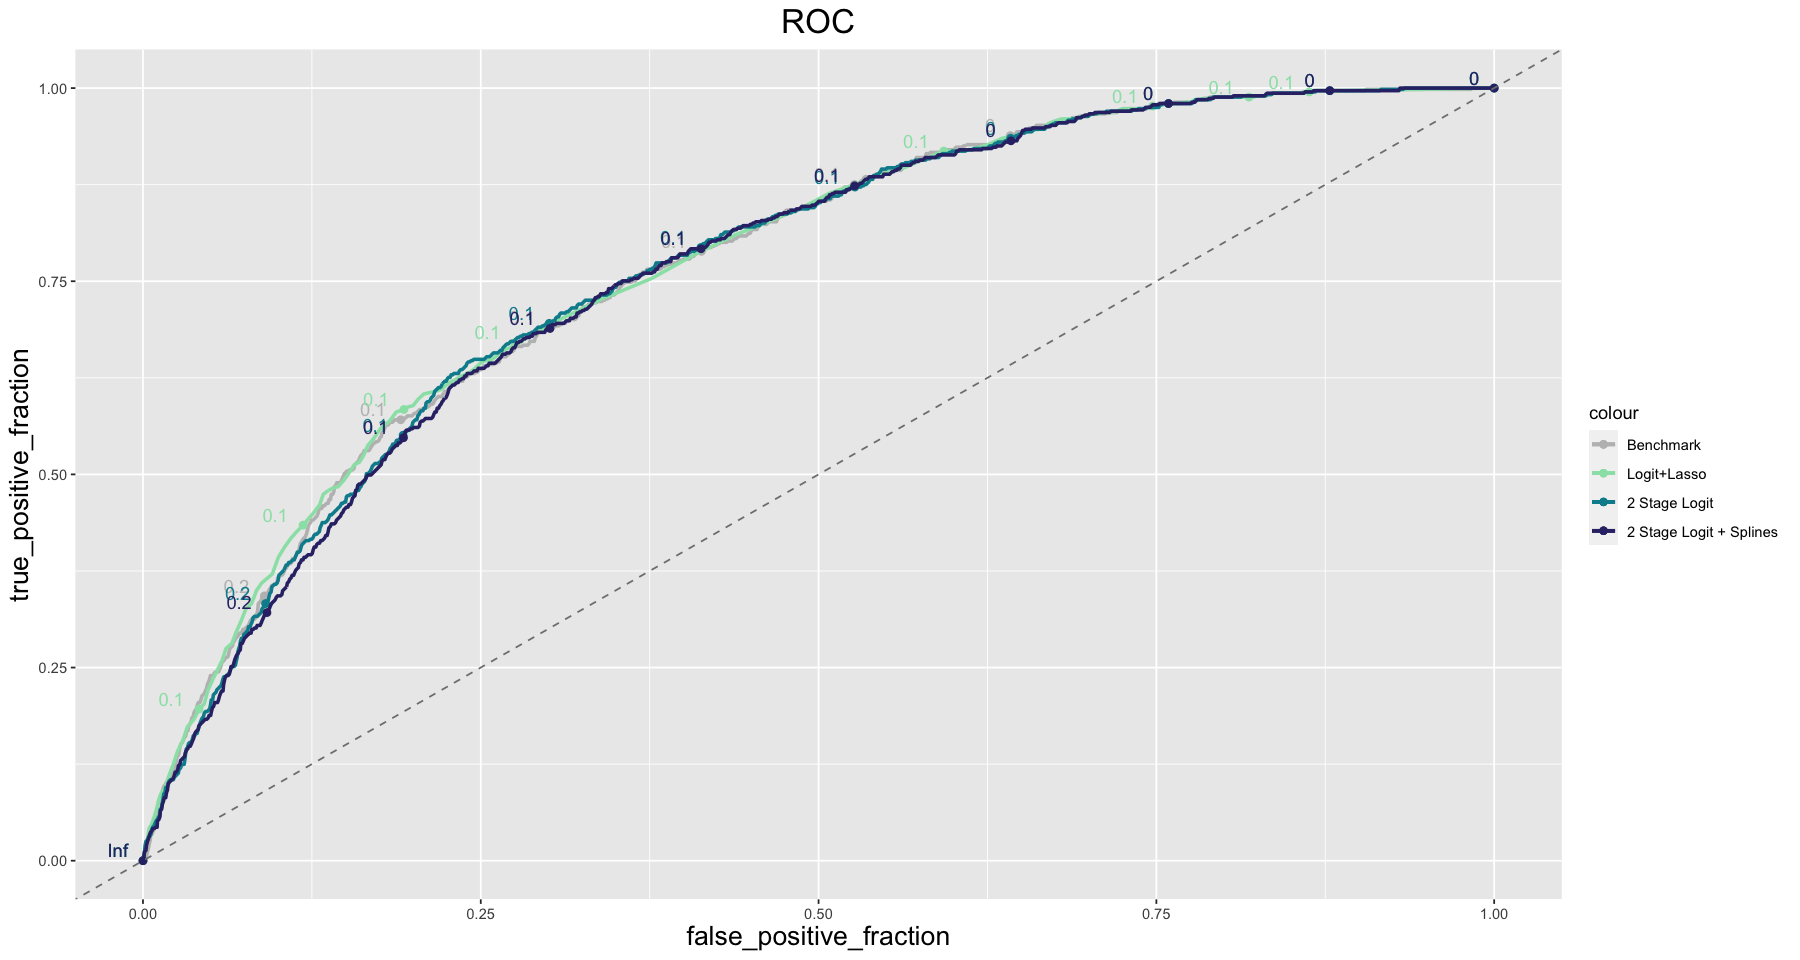

In [346]:
aux_b = cbind(pred_benchmark, won = won_b)
aux_logit_lasso = cbind(pred_lasso, won=raceruns[index_test, target])


colors <- c('Benchmark' = 'grey', 'Logit+Lasso' = '#99E2B4', '2 Stage Logit' = '#008C9B', '2 Stage Logit + Splines' = '#332F75')
roc <- ggplot() + 
        geom_roc(data = aux_b, aes(d = won, m = prediccion, color = 'Benchmark')) +
        geom_roc(data = aux_logit_lasso, aes(d = won, m = prediccion, color = 'Logit+Lasso')) +
        geom_roc(data = pred_clogit_2L, aes(d = won, m = pred_clogit, color = '2 Stage Logit')) +
        geom_roc(data = pred_clogit_2LS, aes(d = won, m = pred_clogit, color = '2 Stage Logit + Splines')) +
        geom_abline(slope = 1, intercept = 0, linetype = 2, color = "grey50") +
        scale_color_manual(values = colors) + 
        ggtitle('ROC') +
        theme(axis.title.x = element_text(size = 16),
        axis.title.y = element_text(size = 16),
        plot.title = element_text(size = 20, hjust = 0.5))

roc

El AUC de cada modelo puede verse en la siguiente tabla

In [296]:
prediobj1 <-prediction(pred_benchmark$prediccion,data.matrix(won_b))
perf1 <-  performance(prediobj1, "tpr","fpr")
auc_benchmark <- as.numeric(performance(prediobj1,"auc")@y.values)

prediobj2 <-prediction(pred_lasso$prediccion,data.matrix(raceruns[index_test , target]))
perf2 <-  performance(prediobj2, "tpr","fpr")
auc_lasso <- as.numeric(performance(prediobj2,"auc")@y.values)

pred_clogit_2L$pred_clogit[is.na(pred_clogit_2L$pred_clogit)] = 0
prediobj3 <- prediction(pred_clogit_2L$pred_clogit, raceruns[index_test , 'won'])                                     
perf3 <- performance(prediobj3,"tpr","fpr")     
auc_2sLogit <- as.numeric(performance(prediobj3,"auc")@y.values)

pred_clogit_2LS$pred_clogit[is.na(pred_clogit_2LS$pred_clogit)] = 0
prediobj4 <- prediction(pred_clogit_2LS$pred_clogit, raceruns[index_test , 'won'])                                     
perf4 <- performance(prediobj4,"tpr","fpr")     
auc_2sLogitSplines <- as.numeric(performance(prediobj4,"auc")@y.values)

auc <- data.frame(benchmark = auc_benchmark,
                    logit_lasso = auc_lasso,
                    logit_2stage = auc_2sLogit,
                    logit_splines_2stage = auc_2sLogitSplines)

auc

benchmark,logit_lasso,logit_2stage,logit_splines_2stage
<dbl>,<dbl>,<dbl>,<dbl>
0.7692232,0.7715769,0.7671112,0.7637305


Si bien el modelo con mayor AUC es el segundo, que solo usa la variable win_odds para predecir, la curva ROC de esta modelo no está siempre por encima de las demás. Vemos que para algunos umbrales resultan mejores los modelos en 2 etapas.

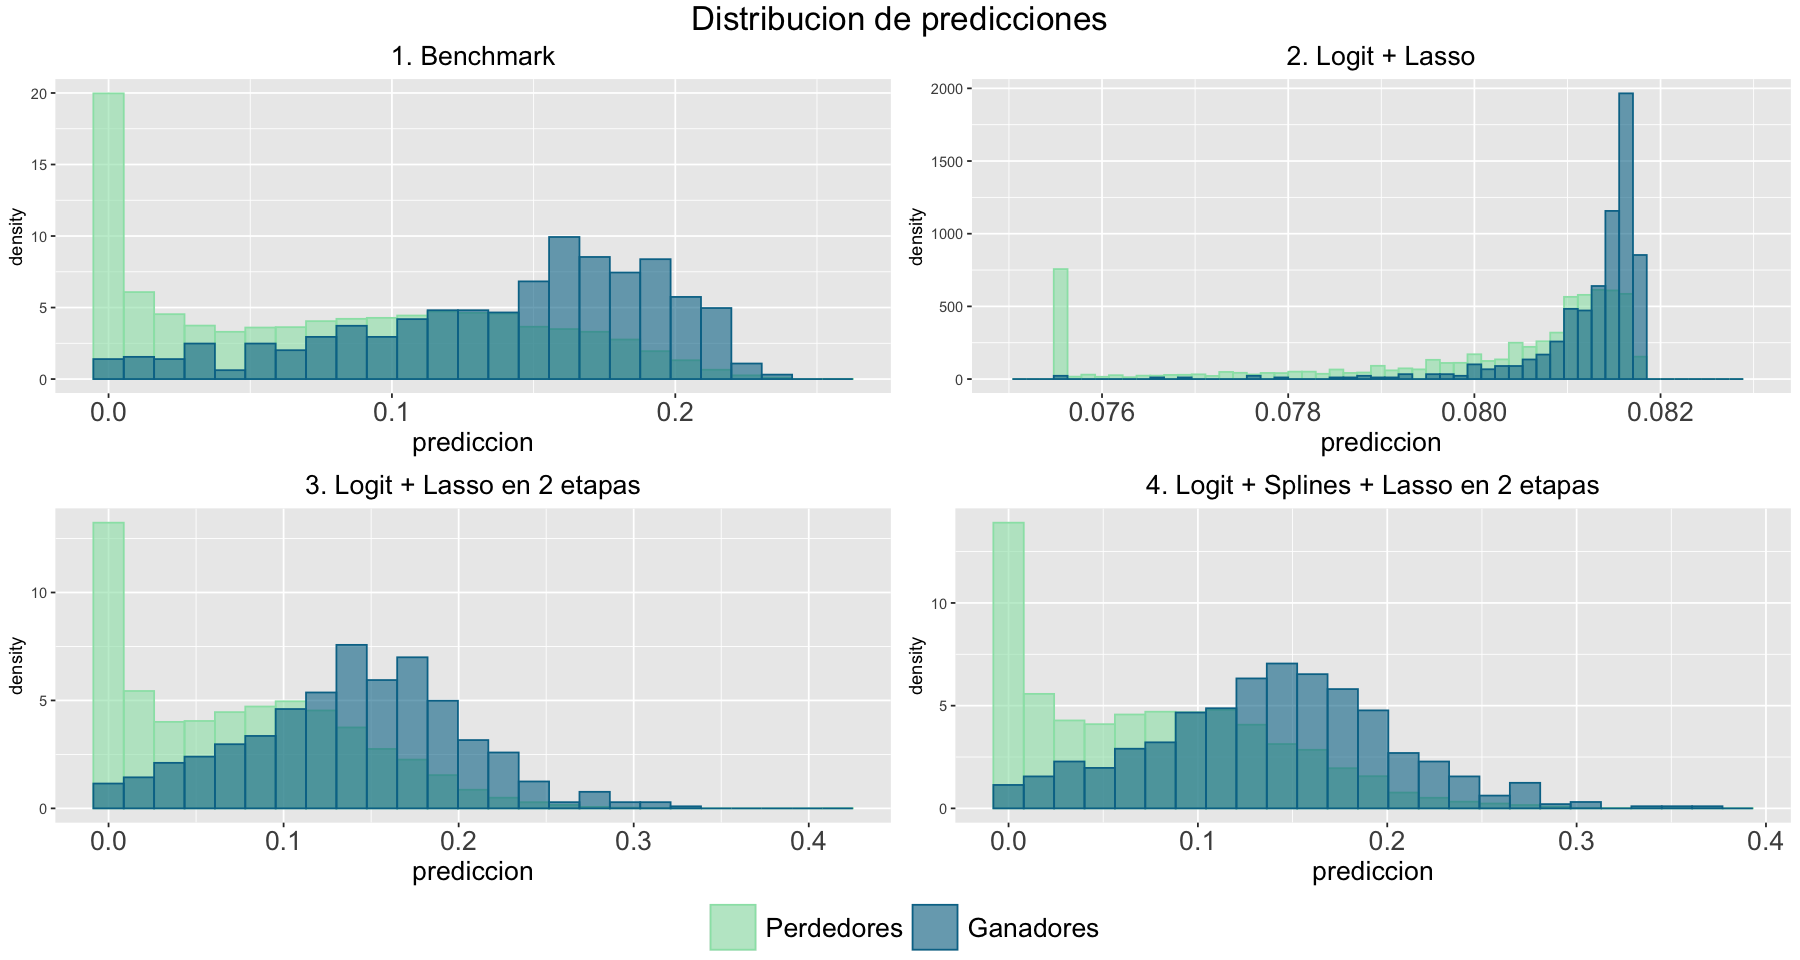

In [347]:
aux_b = cbind(pred_benchmark, won = won_b)
benchmark <- ggplot(data = aux_b, aes(prediccion,y = ..density.., fill = factor(won), color = factor(won))) + 
                  geom_histogram( bins = 25, alpha = 0.6, position = 'identity') +
                  scale_fill_manual(values = c('#99E2B4', '#007496'),name = '', labels = c('Perdedores', 'Ganadores')) +
                  scale_color_manual(values = c('#99E2B4', '#007496'),name = '', labels = c('Perdedores', 'Ganadores')) +
                  theme(legend.position = c(0.8,0.85),
                        legend.title = element_blank()) + 
                  ggtitle('1. Benchmark') + 
                  theme(axis.title.x = element_text(size = 16),
                        plot.title = element_text(size = 16, hjust = 0.5),
                        axis.text.x = element_text(size = 16),
                        legend.position = 'none')

aux_logit_lasso = cbind(pred_lasso, won=raceruns[index_test, target])
logit_lasso <- ggplot(data = aux_logit_lasso, aes(prediccion,y = ..density.., fill = factor(won), color = factor(won))) + 
                  geom_histogram( bins = 55, alpha = 0.6, position = 'identity') +
                  scale_fill_manual(values = c('#99E2B4', '#007496'),name = '', labels = c('Perdedores', 'Ganadores')) +
                  scale_color_manual(values = c('#99E2B4', '#007496'),name = '', labels = c('Perdedores', 'Ganadores')) +
                  theme(legend.position = c(0.8,0.85),
                        legend.title = element_blank()) + 
                  xlim(0.075,0.083) +
                  ggtitle('2. Logit + Lasso') + 
                  theme(axis.title.x = element_text(size = 16),
                        plot.title = element_text(size = 16, hjust = 0.5),
                        axis.text.x = element_text(size = 16),
                        legend.key.size = unit(1, 'cm'), 
                        legend.key.height = unit(1, 'cm'), 
                        legend.key.width = unit(1, 'cm'),
                        legend.text = element_text(size=16), 
                        legend.position = 'bottom')

logit_2s <- ggplot(data = pred_clogit_2L, aes(pred_clogit,y = ..density.., fill = factor(won), color = factor(won))) + 
                  geom_histogram( bins = 25, alpha = 0.6, position = 'identity') +
                  theme(legend.position = c(0.8,0.85),
                        legend.title = element_blank()) + 
                  scale_fill_manual(values = c('#99E2B4', '#007496'), name = '', labels = c('Perdedores', 'Ganadores')) +
                  scale_color_manual(values = c('#99E2B4', '#007496'), name = '', labels = c('Perdedores', 'Ganadores')) +
                  theme(legend.position = c(0.8,0.85),
                        legend.title = element_blank()) + 
                  labs(x = 'prediccion') +
                  ggtitle('3. Logit + Lasso en 2 etapas') + 
                  theme(axis.title.x = element_text(size = 16),
                        plot.title = element_text(size = 16, hjust = 0.5),
                        axis.text.x = element_text(size = 16),
                        legend.position = 'none')

logit_splines_2s <- ggplot(data = pred_clogit_2LS, aes(pred_clogit,y = ..density.., fill = factor(won), color = factor(won))) + 
                        geom_histogram( bins = 25, alpha = 0.6, position = 'identity') +
                        theme(legend.position = c(0.8,0.85),
                              legend.title = element_blank()) + 
                        scale_fill_manual(values = c('#99E2B4', '#007496'), name = '', labels = c('Perdedores', 'Ganadores')) +
                        scale_color_manual(values = c('#99E2B4', '#007496'), name = '', labels = c('Perdedores', 'Ganadores')) +
                        theme(legend.position = c(0.8,0.85),
                              legend.title = element_blank()) + 
                        labs(x = 'prediccion') +
                        ggtitle('4. Logit + Splines + Lasso en 2 etapas') + 
                        theme(axis.title.x = element_text(size = 16),
                              plot.title = element_text(size = 16, hjust = 0.5),
                              axis.text.x = element_text(size = 16),
                              legend.position = 'none')

legend = get_legend(logit_lasso)

plot <- ggarrange(benchmark, logit_lasso, logit_2s, logit_splines_2s, nrow = 2, ncol = 2, legend.grob = legend, legend = 'bottom')

annotate_figure(plot, top = text_grob("Distribucion de predicciones", size = 20))

Graficamos la distribucion de las predicciones para la muestra de test distinguiendo por el resultado de la carrera. Encontramos que todos los modelos hacen un trabajo relativamente bueno prediciendo ganadores, ya que en general predicen probabilidades más altas a los que efectivamente ganaron que a los que no. En particular, el segundo modelo predice probabilidades mas bajas en general, donde las probabilidades mas altas que predicen son de alrededor de 0.082. En cambio, los modelos en dos partes generan distribuciones parecidas, que se mueven en un rango de valores más amplio. Es importante considerar estos rangos a la hora de elegir el umbral.